# Architecture

This notebook is used to design and test out architecture components variations.

In [1]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"

In [2]:
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import time
from IPython.display import clear_output

import tf_utils as tfu

import context_learning as ctl
from context_learning.utils import *

In [3]:
strategy = tfu.strategy.gpu(0)

In [4]:
x_train = np.array([[-1, -1], [-1, 1], [1, -1], [1, 1]])

y_train = np.array([
    [0, 0, 0, 1], # AND
    [0, 1, 1, 1], # OR
    [1, 1, 1, 0], # NAND
    [1, 0, 0, 0], # NOR
    [0, 1, 1, 0], # XOR
    [1, 0, 0, 1], # XNOR
    [0, 0, 1, 1], # Custom A
    [0, 1, 0, 1], # Custom B
])[..., np.newaxis]

In [5]:
BATCH_SIZE = 1

datasets = [] 
for y in y_train:
    dataset = tf.data.Dataset.from_tensor_slices((x_train, y)).batch(BATCH_SIZE)
    dist_dataset = strategy.experimental_distribute_dataset(dataset)
    datasets.append(dist_dataset)
clear_output() # hide shard warnings

In [12]:
ATR_SIZE = 256
SWITCH_THRESHOLD = -0.02
NUM_TASKS = 8

with strategy.scope():
    y = x = keras.layers.Input((2,))
    y = keras.layers.Dense(ATR_SIZE, activation="relu")(y)
    y = ctl.ContextLayer(switch_threshold=SWITCH_THRESHOLD, add_threshold=2*SWITCH_THRESHOLD, verbose=1)(y)
    y = keras.layers.Dense(1, activation="sigmoid")(y)
    model = ctl.ContextModel(x, y, verbose=1)
    model.compile(
        optimizer=keras.optimizers.SGD(1e-1),
        loss=keras.losses.BinaryCrossentropy(from_logits=False))
    model.summary()
    # model.run_eagerly=True

Model: "context_model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               768       
_________________________________________________________________
context_layer_2 (ContextLaye (None, 256)               11        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 257       
Total params: 1,038
Trainable params: 1,025
Non-trainable params: 13
_________________________________________________________________


In [13]:
def train_step(model, batch):
    x = batch[0]
    y = batch[1]
    with tf.GradientTape() as tape:
        y_pred = model(x, training=True)
        loss = model.compiled_loss(y, y_pred)
    grads = tape.gradient(loss, model.trainable_weights)
    model.optimizer.apply_gradients(zip(grads, model.trainable_weights))
    context_grads = [grads[i] for i in model.context_gradient_map]
    return context_grads, loss

@tf.function
def dist_train_step(model, batch):
    grads, losses = strategy.run(train_step, args=(model, batch,))
    
    # Reduce the gradients and add context loss to the model
    grads = strategy.reduce(tf.distribute.ReduceOp.SUM, grads, axis=None)
    model.add_observed_loss(grads)
        
    return strategy.reduce(tf.distribute.ReduceOp.MEAN, losses, axis=None)

In [14]:
history = {
    "loss": [],
    "context_loss_x": defaultdict(list),
    "context_loss_y": defaultdict(list),
    "context_delta": [],
}

epoch = -1

In [15]:
EPOCHS_PER_TASK = 50

with strategy.scope():
    for num_tasks in range(1, NUM_TASKS + 1):
        for i in np.random.permutation(num_tasks):
            dataset = datasets[i]
            start = epoch + 1
            print("\nDataset:", i)
            for epoch in range(start, epoch+EPOCHS_PER_TASK + 1):
                while model.perform_epoch(epoch):
                    history["loss"].append(0)
                    for batch in dataset:
                        loss = dist_train_step(model, batch)
                        history["loss"][-1] += loss
                    print(f"\rGlobal Epoch: {epoch}; Epoch {epoch - start}; Dataset: {i}; Loss: {loss}", end="")
                history["context_loss_x"][model.layers[2].context.value().numpy()].append(epoch)
                history["context_loss_y"][model.layers[2].context.value().numpy()].append(model.layers[2].expected_loss().numpy())
                history["context_delta"].append(model.context_deltas[0].numpy())


Dataset: 0
Global Epoch: 49; Epoch 49; Dataset: 0; Loss: 0.028214903548359874
Dataset: 1
Global Epoch: 50; Epoch 0; Dataset: 1; Loss: 0.01567094214260578
Switching to a new context: 1
Global Epoch: 99; Epoch 49; Dataset: 1; Loss: 0.0025049541145563126
Dataset: 0
Global Epoch: 149; Epoch 49; Dataset: 0; Loss: 0.0064277187921106815
Dataset: 1
Global Epoch: 199; Epoch 49; Dataset: 1; Loss: 0.0010803624754771592
Dataset: 2
Global Epoch: 200; Epoch 0; Dataset: 2; Loss: 7.066687583923347
Switching to a new context: 2
Global Epoch: 249; Epoch 49; Dataset: 2; Loss: 0.010226810351014137
Dataset: 0
Global Epoch: 299; Epoch 49; Dataset: 0; Loss: 0.0021603626664727926
Dataset: 3
Global Epoch: 300; Epoch 0; Dataset: 3; Loss: 0.0012021883158013225
Switching to a new context: 3
Global Epoch: 349; Epoch 49; Dataset: 3; Loss: 0.0016309507191181183
Dataset: 2
Global Epoch: 399; Epoch 49; Dataset: 2; Loss: 0.0029889226425439127
Dataset: 0
Global Epoch: 449; Epoch 49; Dataset: 0; Loss: 0.0027358606457710

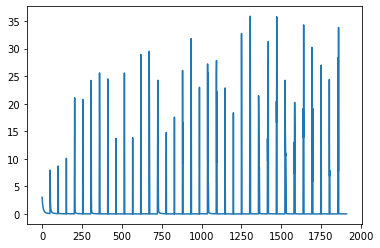

In [16]:
plt.plot(history["loss"])

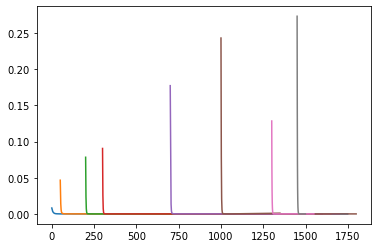

In [17]:
for ctx in history["context_loss_x"]:
    plt.plot(history["context_loss_x"][ctx], history["context_loss_y"][ctx])

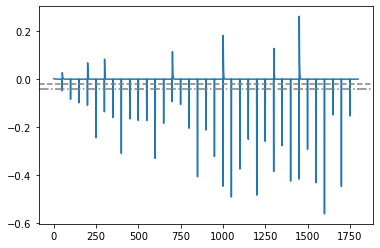

In [18]:
plt.plot(history["context_delta"])
plt.axhline(y=model.layers[2].switch_threshold.value(), color="gray", linestyle="--")
plt.axhline(y=model.layers[2].add_threshold.value(), color="gray", linestyle="-.")

In [19]:
total = 0
for ctx in range(NUM_TASKS):
    model.layers[2].set_context(ctx)
    pred = (model(x_train).numpy() >= 0.5).astype(dtype=np.int32)
    for i in range(len(y_train)):
        if np.all(pred == y_train[i]):
            total += 1
print(f"Accuarcy: {100*total/NUM_TASKS}%")

Accuarcy: 100.0%
